# Run pkasolver demo
### Lindsay Shields
#### November 3, 2022

This notebook was developed as a demo for pkasolver. Proof of performance can be found in notebooks PkaSolver_Run.ipynb and Pkasolver_DataAnalysis.ipynb.

In [1]:
#import dependancies 
import pickle
import pandas as pd
from rdkit import Chem
import torch
from os import path

#import pkasolver
import pkasolver
from pkasolver.query import QueryModel
from pkasolver.ml_architecture import GINPairV1
from pkasolver.query import draw_pka_map 
from pkasolver.query import calculate_microstate_pka_values, draw_pka_reactions
from IPython.display import display
from IPython.display import HTML

#load trained model
base_path=path.dirname(pkasolver.__file__)


### Generator function
Runs pkasolver through a generator function.

This prevents overloading the tmp pickle file and allowing for a bettter dealing of batch sample submission.

In [2]:
def RunPkasolver(x): #takes input of smile object
    protonation_states = calculate_microstate_pka_values(x) #performs internal calculations and stores as object
    sites=len(protonation_states) #get the number of ionization sites 
    
    lst=[]
    for j in range(len(protonation_states)):
        state=protonation_states[j]
        lst.append(round(state.pka,2)) #get pka values for all sites for a given molecule store in a list
    
    yield sites, lst

In [2]:
#import test data
inpt=pd.read_csv('TestData_103122.csv')
inpt.head()

,FunctionalGroup,Specific,Compound,DTXSID,SMILES,Expt_pKa1,Expt_pKa2,Expt_pKa3,Expt_pKa4,CA_pKa1,CA_pKa2,CA_pKa3,CA_pKa4,CA_pKa5,CA_pKa6,Source,Reference,DOI,Reason_for_inclusion
0,Carboxylic Acid,Acetic acids,Acetic acid,DTXSID5024394,CC(O)=O,4.76,NaN,NaN,NaN,4.54,32.68,NaN,NaN,NaN,NaN,pKa-COOH_FullUpdated.xlsx,"Dippy, J.F.J.; Hughes, S.R.C.; Rozanski, A. J....",NaN,perfromed well with chem axon (x-y < 0.3)
1,Phosphate,NaN,Phosphate,DTXSID5024263,OP(O)(O)=O,1.97,6.82,12.5,NaN,1.80,6.95,NaN,NaN,NaN,NaN,pKaMaster.xlsx,"Kumler, W.D.; Eiler, J.J. J. Am. Chem. Soc. 19...",10.1021/ja01252a028,NaN
2,Phosphate,NaN,Methyl-Phosphate,DTXSID2025684,COP(O)(O)=O,1.54,6.31,NaN,NaN,1.83,6.85,NaN,NaN,NaN,NaN,pKaMaster.xlsx,"Kumler, W.D.; Eiler, J.J. J. Am. Chem. Soc. 19...",10.1021/ja01252a028,NaN
3,Phosphate,NaN,Ethyl-Phosphate,DTXSID1044699,CCOP(O)(=O)OCC,1.60,6.62,NaN,NaN,1.95,NaN,NaN,NaN,NaN,NaN,pKaMaster.xlsx,"Kumler, W.D.; Eiler, J.J. J. Am. Chem. Soc. 19...",10.1021/ja01252a028,NaN
4,Phosphate,NaN,Dimethyl-Phosphate,DTXSID5025150,COP(O)(=O)OC,1.29,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN,pKaMaster.xlsx,"Kumler, W.D.; Eiler, J.J. J. Am. Chem. Soc. 19...",10.1021/ja01252a028,NaN


In [7]:
#make an empty results dataframe called results
results=pd.DataFrame(columns=['Compound','DTXSID','SMILES','ps_sites','pka'])

#fill results dataframe with exisitng information
results[['Compound','SMILES','DTXSID']]=inpt[['Compound', 'SMILES','DTXSID']]
results

,Compound,DTXSID,SMILES,ps_sites,pka
0,Acetic acid,DTXSID5024394,CC(O)=O,NaN,NaN
1,Phosphate,DTXSID5024263,OP(O)(O)=O,NaN,NaN
2,Methyl-Phosphate,DTXSID2025684,COP(O)(O)=O,NaN,NaN
3,Ethyl-Phosphate,DTXSID1044699,CCOP(O)(=O)OCC,NaN,NaN
4,Dimethyl-Phosphate,DTXSID5025150,COP(O)(=O)OC,NaN,NaN
...,...,...,...,...,...
128,propan-1-aminium,NaN,CCC[NH3+],NaN,NaN
129,"propane-1,3-bis(aminium)",NaN,[NH3+]CCC[NH3+],NaN,NaN
130,3-carboxypropan-1-aminium,NaN,[NH3+]CCCC(O)=O,NaN,NaN
131,3-sulfopropan-1-aminium,NaN,[NH3+]CCCS(O)(=O)=O,NaN,NaN


### Run pkasolver

On my local machine it takes a few minutes (~10)

In [8]:
#loop through smiles input, calculate pka, and store in results table
for i in results.index:
    smi = inpt['SMILES'][i]
    mol = Chem.MolFromSmiles(smi) #convert string into smile object (rdkit)
    data = RunPkasolver(mol) # run smile object through generator function to get pka and num of ionionizable sites
    
    #sep out generator yield and save to results table
    for n,p in data:
        results['pka'][i]=p
        results['ps_sites'][i]=n
results

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=P([O-])([O-])[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: COP(=O)([O-])[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCOP(=O)([O-])OCC


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: COP(=O)([O-])OC


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCOP(=O)([O-])OCCCC


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCOP(=O)(OCCC)OCCC
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCOP(=O)(OCCCC)OCCCC
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCOP(=O)(OCC)OCC
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])Cc1ccc([S-])cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCS


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=S(=O)([O-])CCS


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Nc1ccccc1[S-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [S-]c1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])CCS


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: COC(=O)[C@@H]([NH3+])CS


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [S-]c1ccc(Cl)cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C12CCC(CC1)CC2


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCOC(=O)C12CCC(C(=O)[O-])(CC1)CC2


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: N#CC12CCC(C(=O)[O-])(CC1)CC2


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C12CCC(O)(CC1)CC2


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C12CCC(Br)(CC1)CC2


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C(Cl)Cl


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: N#CSCC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: OCC(O)CO


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Oc1ccncc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Oc1cnc2ccccc2c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Oc1cccc2cccnc12


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Cc1ccccc1O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Cc1cccc(O)c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Cc1ccc(O)cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Oc1cccc(Cl)c1Cl


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=[N+]([O-])c1ccc(O)c([N+](=O)[O-])c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=[N+]([O-])c1cccc([N+](=O)[O-])c1O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CCS)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1ccc(O)cc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1cccc(O)c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CCCC(=O)[O-])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Cn1cnc(CC([NH3+])C(=O)[O-])c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Cn1cncc1CC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1cc(I)c(O)c(I)c1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1ccc(O)c(I)c1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1ccc(O)c(O)c1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC(=O)NC(Cc1cnc[nH]1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC(=O)NC(Cc1cnc[nH]1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CCC(=O)NC(CS)C(=O)NCC(=O)[O-])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NC(NC(CC(=O)[O-])C(=O)[O-])=[NH+]CCCC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NC(=[NH2+])NCCCC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CS)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CO)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CS(=O)(=O)[O-])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CC(=O)[O-])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NC(=O)CC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(O)C([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])C1CCC[NH2+]1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(CCC(=O)[O-])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(C)C([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CSCCC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1cnc[nH]1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCC(C)C([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC(C)CC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCC([NH3+])C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1ccccc1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1ccc(O)cc1)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(Cc1c[nH]c2ccccc12)C(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C(OO)c1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1cccc2cc3ccccc3cc12


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1c2ccccc2cc2ccccc12


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1ccc2ccccc2c1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: O=C([O-])c1cccc2ccccc12


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: N
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: N
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NO
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Nc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NN
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: C[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C(F)F


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]Cc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: C=CC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]C[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCO


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCc1ccccc1


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: N
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NS(=O)(=O)[O-]
#########################
Could not identify any ionizable group. Aborting.
#########################


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: NP(=O)([O-])O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCS(=O)(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCP(=O)([O-])O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCS(=O)(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCP(=O)([O-])O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCS(=O)(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCP(=O)([O-])O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCCCCCCCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCCCCCCS(=O)(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCCCCCCCCP(=O)([O-])O


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCC[NH3+]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCC(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: [NH3+]CCCS(=O)(=O)[O-]


[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: CCCC[NH3+]


,Compound,DTXSID,SMILES,ps_sites,pka
0,Acetic acid,DTXSID5024394,CC(O)=O,1,[4.19]
1,Phosphate,DTXSID5024263,OP(O)(O)=O,1,[2.83]
2,Methyl-Phosphate,DTXSID2025684,COP(O)(O)=O,1,[2.56]
3,Ethyl-Phosphate,DTXSID1044699,CCOP(O)(=O)OCC,1,[4.66]
4,Dimethyl-Phosphate,DTXSID5025150,COP(O)(=O)OC,1,[4.06]
...,...,...,...,...,...
128,propan-1-aminium,NaN,CCC[NH3+],1,[10.77]
129,"propane-1,3-bis(aminium)",NaN,[NH3+]CCC[NH3+],1,[11.19]
130,3-carboxypropan-1-aminium,NaN,[NH3+]CCCC(O)=O,2,"[5.07, 10.61]"
131,3-sulfopropan-1-aminium,NaN,[NH3+]CCCS(O)(=O)=O,1,[9.65]


### Format pka results

In [9]:
#separate pka values from list to individual columns
sep=pd.DataFrame(results.pka.tolist()).add_prefix('PS_pKa')

#combine pka columns with rest of data
psResults=pd.concat([results,sep],axis=1)
psResults

,Compound,DTXSID,SMILES,ps_sites,pka,PS_pKa0,PS_pKa1,PS_pKa2,PS_pKa3,PS_pKa4,PS_pKa5,PS_pKa6,PS_pKa7,PS_pKa8
0,Acetic acid,DTXSID5024394,CC(O)=O,1,[4.19],4.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Phosphate,DTXSID5024263,OP(O)(O)=O,1,[2.83],2.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Methyl-Phosphate,DTXSID2025684,COP(O)(O)=O,1,[2.56],2.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ethyl-Phosphate,DTXSID1044699,CCOP(O)(=O)OCC,1,[4.66],4.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dimethyl-Phosphate,DTXSID5025150,COP(O)(=O)OC,1,[4.06],4.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,propan-1-aminium,NaN,CCC[NH3+],1,[10.77],10.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,"propane-1,3-bis(aminium)",NaN,[NH3+]CCC[NH3+],1,[11.19],11.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,3-carboxypropan-1-aminium,NaN,[NH3+]CCCC(O)=O,2,"[5.07, 10.61]",5.07,10.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,3-sulfopropan-1-aminium,NaN,[NH3+]CCCS(O)(=O)=O,1,[9.65],9.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visual result options

In [10]:
example='OC1=CC=NC=C1'
smi=Chem.MolFromSmiles(example)
protonation_states=calculate_microstate_pka_values(smi)

[query.py:297 - calculate_microstate_pka_values()] Using dimorphite-dl to identify protonation sites.


Proposed mol at pH 7.4: Oc1ccncc1


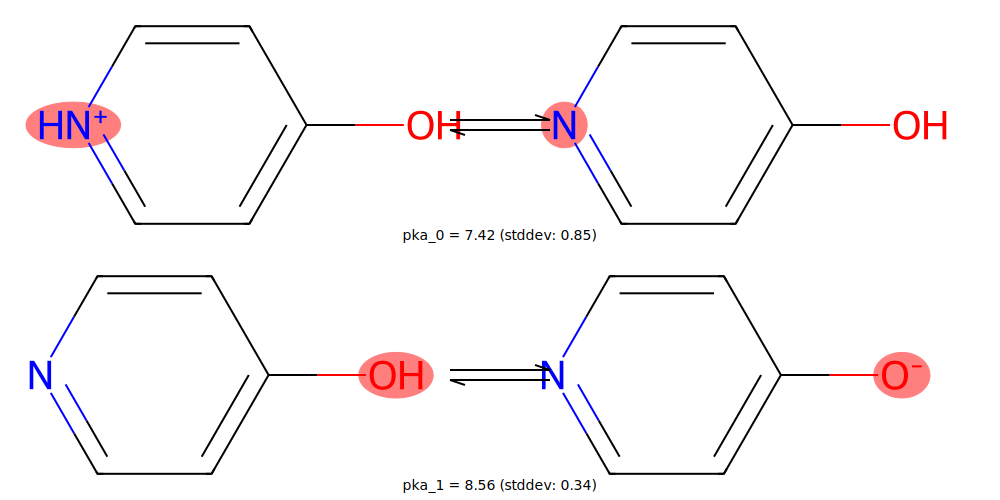

In [11]:
#draw the micostate pka values
calc = draw_pka_reactions(protonation_states)
display(calc)

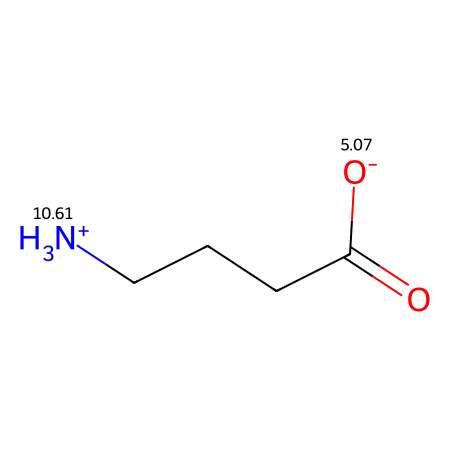

In [9]:
# visualize them on the molecule at pH=7.0
draw_pka_map(protonation_states)